In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import nengo
from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ipython import hide_input
from nengo.utils.matplotlib import rasterplot


def aligned(n_neurons, radius=0.9):
    intercepts = np.linspace(-radius, radius, n_neurons)
    encoders = np.tile([[1], [-1]], (n_neurons // 2, 1))
    intercepts *= encoders[:, 0]
    return intercepts, encoders


### Basics

In [5]:
net = nengo.Network()
with net: 
    node = nengo.Node(np.array([0.6, -0.5]))
    ensemble = nengo.Ensemble(25, 2)
    nengo.Connection(node, ensemble)
    nop = nengo.Probe(node)
    ep = nengo.Probe(ensemble)

In [6]:
with nengo.Simulator(net) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

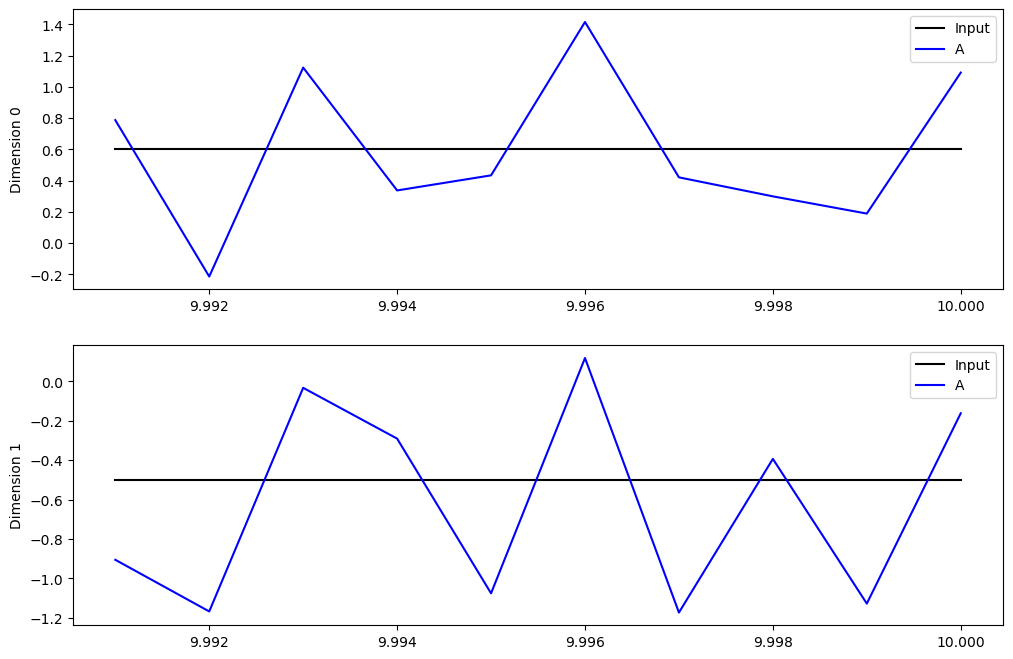

In [9]:
dims_to_observe = [0, 1]
D = len(dims_to_observe)
plt.figure(figsize=(6*D, 8))
for i, d in enumerate(dims_to_observe):
    plt.subplot(D, 1, i+1)
    plt.plot(sim.trange()[-10:], sim.data[nop].T[d][-10:], c="k", label="Input")
    plt.plot(sim.trange()[-10:], sim.data[ep].T[d][-10:], c="b", label="A")
    #plt.plot(sim.trange(), sim.data[B_p].T[d], c="r", label="B")
    plt.ylabel(f"Dimension {d}")
    plt.legend(loc="best")

plt.show()

## Nengo Quickstart 
- Represent Information as real numbers/ vectors
- N neurons in population form distributed representation for k-dimensional real-vector. The *activity* of the neurons is the actual state of their voltages while the *value* is some vector they represent. More neurons are more accurate representations of value. 
- Encoding Process $E: \mathbb R^N \rightarrow \mathbb R^k$ relies on *direction vector* $e_i$
$$\hat{x} = \sum a_i d_i$$
- Decoding Process $D: \mathbb R^k \rightarrow \mathbb R^N$
$$a_i = G(\alpha_i e_i \cdot x + b_i)$$

G represents any non-linearity for a model of the brain. By default, Nengo uses Integrate and Fire neurons, but can also be LIF, sigmoidal neurons, or something more complex. 


Some details/ resources
- [Forums](https://forum.nengo.ai/t/basic-concept-of-essemble-and-connection/2080) on encoding/decoding
- Walkthrough of how Nengo illustrates the [Neural Engineering Framework](https://www.nengo.ai/nengo/examples/advanced/nef-summary.html?highlight=nef), which there is a textbook on
- Deep dive on [Connections](https://www.nengo.ai/nengo/connections.html#id6)

In [45]:
N = 100
k = 2
net = nengo.Network()
with net:
    stim = nengo.Node(output=np.array([0.5, 0.8]), label='stim')
    A = nengo.Ensemble(n_neurons=N, dimensions=k, label='A')
    #B = nengo.Ensemble(n_neurons=N, dimensions=k, label='B')
    nengo.Connection(stim, A)
    ens_probe = nengo.Probe(A, synapse=0.01)
    neur_probe = nengo.Probe(A.neurons, synapse=0.01)

In [46]:
sim = nengo.Simulator(net)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [47]:
sim.run(2.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [48]:
list(sim.data.keys())

[<Ensemble 'A' at 0x1368ebfd0>,
 <Node 'stim' at 0x135456c50>,
 <Connection at 0x1363b6c50 from <Node 'stim'> to <Ensemble 'A'>>,
 <Connection at 0x136531310 from <Ensemble 'A'> to <Probe of 'decoded_output' of <Ensemble 'A'>>>,
 <Probe at 0x1365856d0 of 'decoded_output' of <Ensemble 'A'>>,
 <Probe at 0x13658de50 of 'output' of <Neurons of <Ensemble 'A'>>>,
 <Network (unlabeled) at 0x136587f10>]

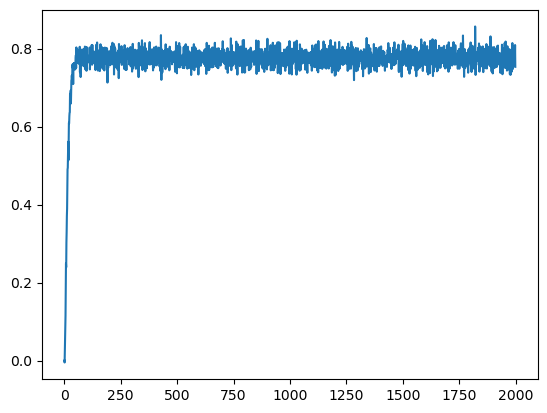

In [50]:
sim.data[ens_probe] # Txk
plt.plot(sim.data[ens_probe][:, 1])
plt.show()

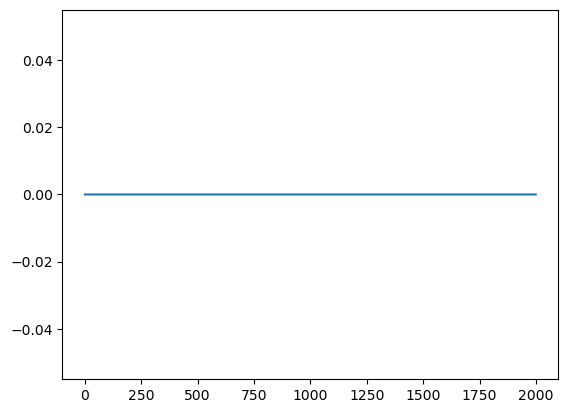

In [38]:
sim.data[neur_probe] # T x N

plt.plot(sim.data[neur_probe][:, 19])
plt.show()

In [57]:
p = A.encoders.sample(N, d=k)
q = A.encoders.sample(N, d=k)

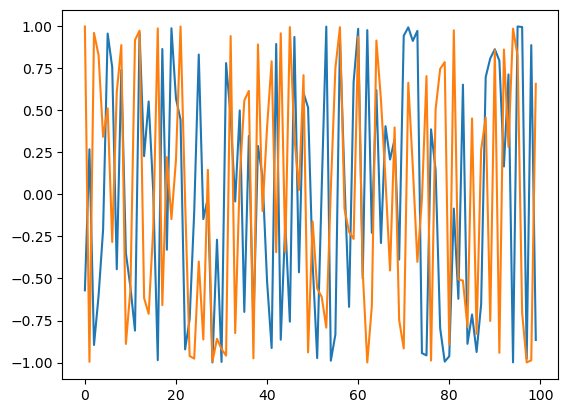

In [66]:
plt.plot(p[:,0])
plt.plot(q[:,0])
plt.show()

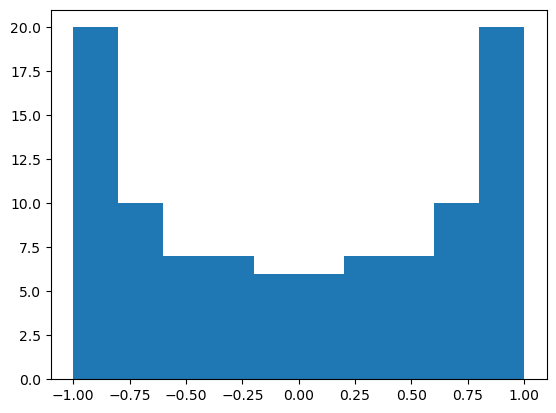

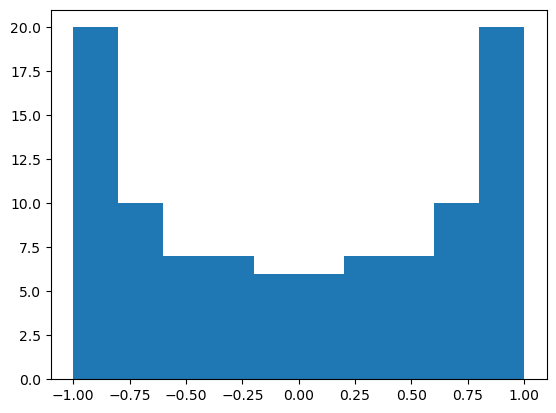

In [65]:
plt.hist(p[:,0])
plt.show()

plt.hist(q[:,1])
plt.show()

## NEF Walkthrough

In [3]:
def aligned(n_neurons, radius=0.9):
    intercepts = np.linspace(-radius, radius, n_neurons)
    encoders = np.tile([[1], [-1]], (n_neurons // 2, 1))
    intercepts *= encoders[:, 0]
    return intercepts, encoders

In [4]:
model = nengo.Network(label="NEF summary")
with model:
    input = nengo.Node(lambda t: t * 2 - 1)
    input_probe = nengo.Probe(input)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

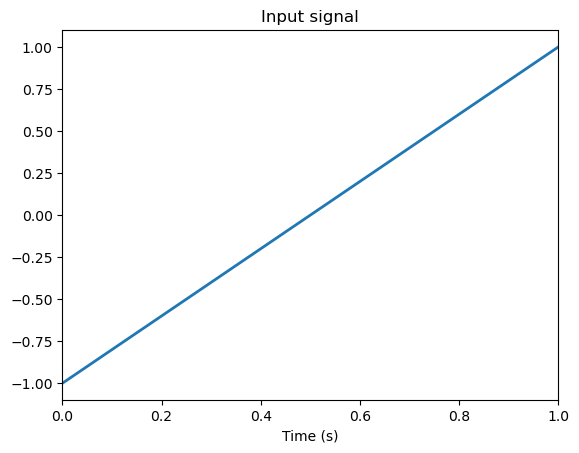

In [5]:
with nengo.Simulator(model) as sim:
    sim.run(1.0)
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], lw=2)
plt.title("Input signal")
plt.xlabel("Time (s)")
plt.xlim(0, 1)
plt.show()

In [6]:
intercepts, encoders = aligned(8)  # Makes evenly spaced intercepts

In [18]:

with model:
    A = nengo.Ensemble(8, dimensions=1,
        intercepts=intercepts,
        max_rates=Uniform(80, 100),
        encoders=encoders,
    )
    conn = nengo.Connection(input, A)
    A_spikes = nengo.Probe(A.neurons, synapse=0.01)
    A_probe = nengo.Probe(A, synapse=0.01)
    #conn_probe = nengo.Probe(conn)

In [19]:
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(A, sim)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [20]:
list(zip(intercepts, encoders))

[(-0.9, array([1])),
 (0.6428571428571428, array([-1])),
 (-0.3857142857142857, array([1])),
 (0.12857142857142845, array([-1])),
 (0.12857142857142867, array([1])),
 (-0.3857142857142858, array([-1])),
 (0.6428571428571431, array([1])),
 (-0.9, array([-1]))]

(50, 1) (50, 8)


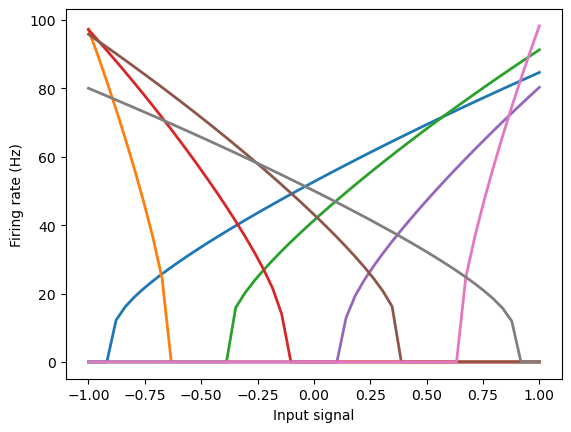

In [21]:
print(eval_points.shape, activities.shape)
plt.figure()
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)")
plt.show()

In [27]:
with nengo.Simulator(model) as sim:
    sim.run(1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

### Decoding

In [32]:
model = nengo.Network(label="NEF summary")
with model:
    input = nengo.Node(lambda t: t * 2 - 1)
    input_probe = nengo.Probe(input)
    intercepts, encoders = aligned(8)  # Makes evenly spaced intercepts
    A = nengo.Ensemble(8, dimensions=1,
        intercepts=intercepts,
        max_rates=Uniform(80, 100),
        encoders=encoders,
    )
    nengo.Connection(input, A)
    A_spikes = nengo.Probe(A.neurons, synapse=0.01)
    A_probe = nengo.Probe(A, synapse=0.01)  # 10ms PSC filter

In [33]:
with nengo.Simulator(model) as sim:
    sim.run(1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

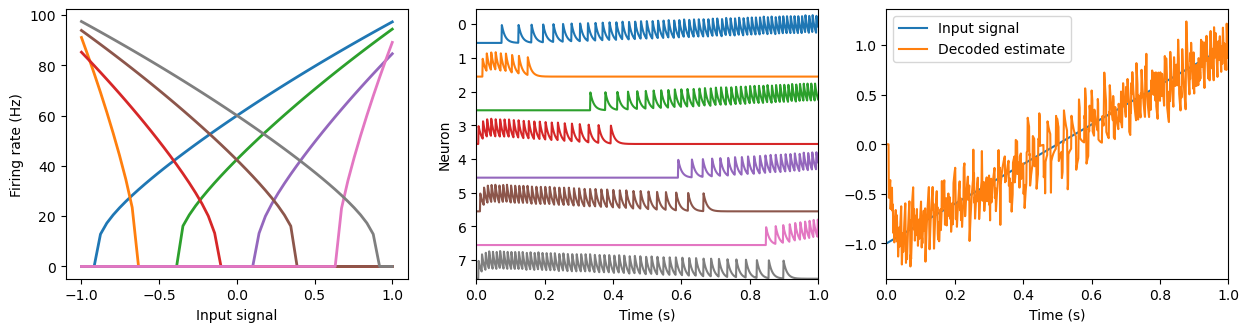

In [34]:
plt.figure(figsize=(15, 3.5))

plt.subplot(1, 3, 1)
eval_points, activities = tuning_curves(A, sim)
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)")

plt.subplot(1, 3, 2)
scale = 180
for i in range(A.n_neurons):
    plt.plot(sim.trange(), sim.data[A_spikes][:, i] - i * scale)
plt.xlim(0, 1)
plt.ylim(scale * (-A.n_neurons + 1), scale)
plt.ylabel("Neuron")
plt.yticks(
    np.arange(scale / 1.8, (-A.n_neurons + 1) * scale, -scale), np.arange(A.n_neurons)
)
plt.xlabel("Time (s)")
plt.ylabel("Neuron")

plt.subplot(1, 3, 3)
plt.plot(sim.trange(), sim.data[input_probe], label="Input signal")
plt.plot(sim.trange(), sim.data[A_probe], label="Decoded estimate")
plt.legend(loc="best")
plt.xlabel("Time (s)")
plt.xlim(0, 1)
plt.show()

## Honing in on Neural Representation - Example Gallery



### [Single Neuron Example](https://www.nengo.ai/nengo/examples/basic/single-neuron.html)

LIF Neuron

$C_m \dfrac{dV}{dt} = - g_L (V - E_L) + I$

In [18]:
from nengo.dists import Uniform

single_neuron_model = nengo.Network(label="A Single Neuron")

with single_neuron_model:
    neuron = nengo.Ensemble(1,
        dimensions=1,  # Represent a scalar
        # Set intercept to 0.5
        intercepts=Uniform(-0.5, -0.5),
        # Set the maximum firing rate of the neuron to 100hz
        max_rates=Uniform(100, 100),
        # Set the neuron's firing rate to increase for positive input
        encoders=[[1]],
        label='single_neuron'
    )

    cos_input = nengo.Node(lambda t: np.cos(8 * t), label='cos_input')
    nengo.Connection(cos_input, neuron)

    cos_probe = nengo.Probe(cos_input)
    # The raw spikes from the neuron
    spikes = nengo.Probe(neuron.neurons)
    # Subthreshold soma voltage of the neuron
    voltage = nengo.Probe(neuron.neurons, "voltage")
    # Spikes filtered by a 10ms post-synaptic filter
    filtered = nengo.Probe(neuron, synapse=0.01)


In [19]:
with nengo.Simulator(single_neuron_model) as sim:  # Create the simulator
    sim.run(2)  # Run it for 1 second

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [20]:
for key in list(sim.data):
    print(key)

<Ensemble 'single_neuron'>
<Node 'cos_input'>
<Connection from <Node 'cos_input'> to <Ensemble 'single_neuron'>>
<Probe of 'output' of <Node 'cos_input'>>
<Probe of 'output' of <Neurons of <Ensemble 'single_neuron'>>>
<Probe of 'voltage' of <Neurons of <Ensemble 'single_neuron'>>>
<Connection from <Ensemble 'single_neuron'> to <Probe of 'decoded_output' of <Ensemble 'single_neuron'>>>
<Probe of 'decoded_output' of <Ensemble 'single_neuron'>>
<Network "A Single Neuron">


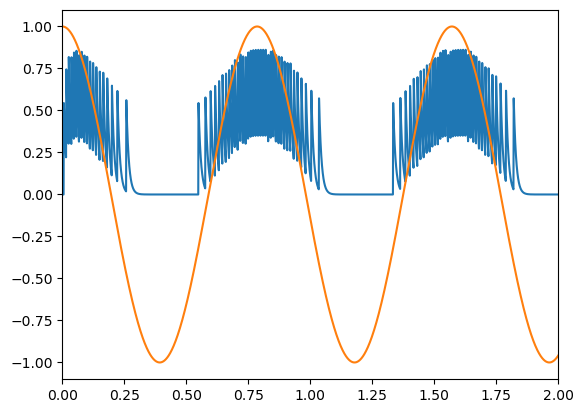

In [23]:
# Plot the decoded output of the ensemble
plt.plot(sim.trange(), sim.data[filtered])
plt.plot(sim.trange(), sim.data[cos_probe])
plt.xlim(0, 2)
plt.show()

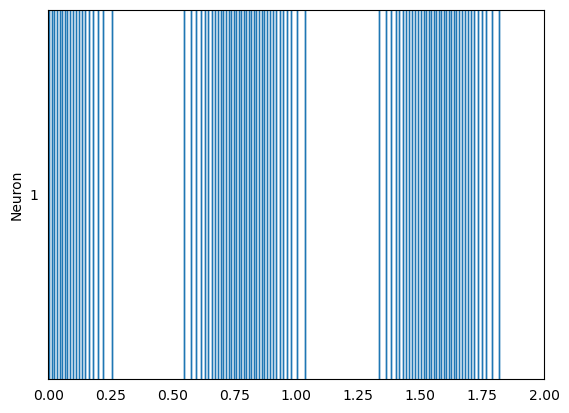

In [25]:
rasterplot(sim.trange(), sim.data[spikes])
plt.ylabel("Neuron")
plt.xlim(0, 2)
plt.show()

In [31]:
neuron.neurons

<Neurons at 0x126a8b850 of <Ensemble 'single_neuron' at 0x1266a7c50>>

In [69]:
2*np.eye(2)

array([[2., 0.],
       [0., 2.]])

In [70]:
with nengo.Network() as net:
    ens1 = nengo.Ensemble(10, dimensions=1)
    ens2 = nengo.Ensemble(20, dimensions=2)

    # Neuron to neuron
    weights = np.random.normal(size=(ens2.n_neurons, ens1.n_neurons))
    nengo.Connection(ens1.neurons, ens2.neurons, transform=weights)
    nprobe1 = nengo.Probe(ens1.neurons, synapse=0.01)
    nprobe2 = nengo.Probe(ens2.neurons, synapse=0.01)
    probe1 = nengo.Probe(ens1, synapse=0.01)
    probe2 = nengo.Probe(ens2, synapse=0.01)

In [71]:
sim = nengo.Simulator(net)
sim.run(2.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [73]:
weights

array([[ 0.48796207,  0.31267642, -0.4613728 ,  1.12395032,  0.22143892,
         0.72308121,  0.42145681, -1.33615117,  0.05407587, -1.1076657 ],
       [ 0.92618097,  1.04226155,  1.36443547, -0.78794561, -0.63196008,
        -0.68165421,  0.98391638, -1.06195855,  0.33846863,  0.91992602],
       [ 0.11513031, -0.79720507, -0.88755665, -0.94965523,  0.37353084,
         0.12797576,  0.08582479, -0.27302326,  1.06985995,  0.97469278],
       [ 0.80934416,  0.75556433, -2.34492117,  0.8339394 , -0.99743479,
        -0.72024247, -0.69867032, -0.230769  , -0.37408646, -0.0249662 ],
       [ 1.40402962, -0.00596063,  1.95518474,  0.4440213 , -0.03019086,
        -1.65991408,  0.23371083,  0.48496849,  0.49364345,  0.41485898],
       [-0.11077252,  0.30660146, -0.68558649, -0.71835143,  2.06002192,
         0.44633746, -0.14717598,  0.09091342, -1.2191363 , -0.46143158],
       [ 0.2183782 ,  1.69851489, -0.51359349, -1.73593452, -0.08655426,
         0.68115252, -0.01607831,  1.73259661

In [82]:
a1 = sim.data[nprobe1]
a2 = sim.data[nprobe2]

In [83]:
a1.shape, a2.shape, weights.shape

((2000, 10), (2000, 20), (20, 10))

In [84]:
a2_hat = np.dot(weights, a1.T).T
a2_hat.shape

(2000, 20)

In [92]:
err = (a2_hat - a2).mean(axis=1)

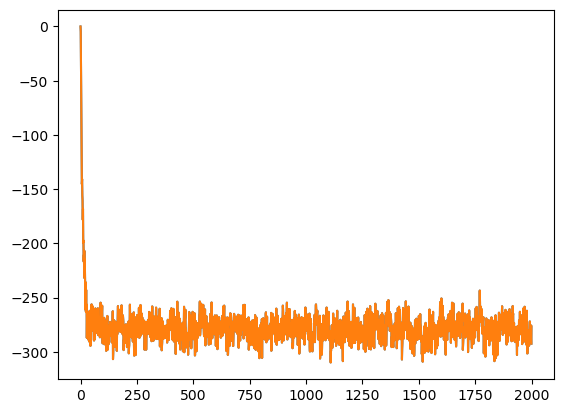

In [95]:
plt.plot(err)
plt.show()

In [ ]:
with nengo.Network() as net:
    stim = nengo.Node(output=np.array([0.5, 0.8]), label='stim') 
    ens1 = nengo.Ensemble(2, dimensions=1)
    ens2 = nengo.Ensemble(2, dimensions=1)

    # Neuron to neuron
    weights = np.random.normal(size=(ens2.n_neurons, ens1.n_neurons))
    nengo.Connection(ens1.neurons, ens2.neurons, transform=weights)
    